In https://www.bogleheads.org/forum/viewtopic.php?f=10&t=192105&start=200#p2986911
longinvest said, "It would be quite interesting to see the portfolio and withdrawal
trajectory of 30/70, 40/60, and maybe 50/50 (stocks/bonds) constant AA portfolios vs
Prime Harvesting in both nominal and inflation-adjusted term, and look at the result
with the eye of a retiree who sees nominal numbers on his bank account and mutual fund
statements.

So let's try to do that.

[siamond has an investigation here](https://www.bogleheads.org/forum/viewtopic.php?f=10&t=192105&start=200#p2986703)
My charts and his look the same, which is good. (Though he shows 40 years and I only show 25)

He implements VPW a bit differently than I do, so the VPW charts look different.
- He doesn't take into account the changing asset allocation
- He uses a longer-than-default timespan (50 years instead of 35)

How to judge the success or failure of Prime Harvesting?

The most important thing is how much money you get over your life time. If you don't get more money it isn't
even worth looking at other parameters.

Only *after* that should we start looking at measures of risk. What kinds of measures of risk?
- Total portfolio balance
- Standard deviation
- Percentage of bonds
- Milevsky's "risk quotient"?

Use stochastic mortality.

In [1]:
%matplotlib inline
from decimal import Decimal
import itertools
from pprint import pprint
import math

import pandas
import seaborn
from matplotlib import pyplot as plt
plt.style.use('seaborn-poster')

import metrics
import simulate
import harvesting
import market
import plot
import mortality
from plot import plt
from withdrawal import VPW, RetrenchmentRule, ConstantDollar, EM, ECM, SteinerSmoothing, LonginvestSmoothing
from portfolio import Portfolio
import montecarlo

In [2]:
#series = market.Returns_US_1871()
#START_YEAR=1871

series = market.Japan_1957()
START_YEAR=1957

In [3]:
x = simulate.withdrawals(series.iter_from(1966),
                                 withdraw=lambda p, s: LonginvestSmoothing(VPW(p, s, years_left=50)),
                                 years=30,
                                 portfolio=(1000000, 0),
                                 harvesting=harvesting.make_rebalancer(1))
#[float(n.withdraw_n) for n in x]

In [4]:
def test_all(year, strategies_to_test, years=25):
    results = {}
    for h in strategies_to_test:
        starting_portfolio = (600000,400000)

        # siamond used VPW with a 50 year depletion period, so I'll try that as well
        x = simulate.withdrawals(series.iter_from(year),
                                 withdraw=lambda p, s: VPW(p, s, years_left=35),
                                 #withdraw=lambda p, s: ConstantDollar(p, s, rate=Decimal('.026')),
                                 #withdraw=lambda p, s: SteinerSmoothing(VPW(p, s, years_left=50)),
                                 #withdraw=lambda p, s: RetrenchmentRule(p, s),
                                 years=years,
                                 portfolio=starting_portfolio,
                                 harvesting=h)
        results[h.__name__] = x
    return results

In [5]:
def make_data_tables(strategies_to_test, lens, years=25):
    frames = {}
    
    for s in strategies_to_test:
        frames[s.__name__] = pandas.DataFrame(columns=['Y%02d' % y for y in range(years)])
        
    last_year = 2015 - years
    
    for i in range(START_YEAR, last_year):
        n = test_all(i, strategies_to_test, years=years)
        for s in n.keys():
            frames[s].loc[i] = [lens(_) for _ in n[s]]

    return frames

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case.

We prefer lower kurtosis.

The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. Negative values for the skewness indicate data that are skewed left and positive values for the skewness indicate data that are skewed right. By skewed left, we mean that the left tail is long relative to the right tail. Similarly, skewed right means that the right tail is long relative to the left tail. If the data are multi-modal, then this may affect the sign of the skewness.

We want skewness to be higher.

In [6]:
def semideviation(frame):
    #goal = frame.mean()
    goal = 40000
    values = frame[lambda s: s < goal]
    sumvalues = sum(((goal - v) ** 2 for v in values))
    average = sumvalues / len(values)
    return math.sqrt(average)


def calculate_stuff(df, use_all_columns=True):
    """
    Things we don't yet calculate.
    Real returns (that an investor sees)
    Average asset allocation of bonds
    Minimum asset allocation of bond
    """
    
    if use_all_columns:
        stack = df.stack()
    else:
        columns = df.columns.tolist()
        stack = df[columns[-1]]
    
    return ({
            'Mean': round(stack.mean()),
            'Median' : round(stack.median()),
            'Stddev': stack.std() / stack.mean(),
            'Min': stack.min(),
            'Max' : stack.max(),
            ' 5th percentile' : round(stack.quantile(.05)),
            '10th percentile' : round(stack.quantile(.1)),
            '90th percentile' : round(stack.quantile(.9)),
            'Mean of 25% lowest' : round(stack.nsmallest(int(len(stack) / 4)).mean()),
            'Kurtosis' : stack.kurtosis(),
            'Skew' : stack.skew(),
            'Semidev-4' : semideviation(stack),
    })

/home/justus/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


,5th percentile,10th percentile,90th percentile,Kurtosis,Max,Mean,Mean of 25% lowest,Median,Min,Semidev-4,Skew,Stddev
100% Stocks,25688.0,33369.0,133597.0,4.564539,341961.758789,77886.0,36190.0,67550.0,11803.312846,13897.335615,1.782512,0.574596
35% Stocks,29679.0,32094.0,76866.0,0.220844,109437.670664,51336.0,32745.0,49374.0,23353.923768,7452.943018,0.789582,0.326088
60% Stocks,36253.0,39632.0,88580.0,1.983789,147507.240672,60600.0,39812.0,56018.0,26409.322982,5830.069721,1.292644,0.342080
AgeBased_100,26296.0,29053.0,82484.0,-0.336330,101244.135312,50637.0,29753.0,45712.0,20569.605672,9048.021039,0.766590,0.387278
AgeBased_110,29814.0,33231.0,81457.0,-0.378214,110929.598136,54086.0,33543.0,49904.0,23001.806352,7453.054542,0.619596,0.337893
AgeBased_120,33180.0,36762.0,82786.0,0.111616,125333.639712,57687.0,37217.0,54708.0,25492.533360,6478.792167,0.629523,0.310601
AltPrimeHarvesting,33532.0,40440.0,97447.0,2.932023,195667.683012,65173.0,40130.0,58955.0,20459.974964,9167.415355,1.461544,0.397098
BondsFirst,24859.0,33130.0,118773.0,3.823358,272218.471741,70507.0,34765.0,60762.0,12607.330572,13677.989566,1.721866,0.548648
Glidepath,30944.0,35148.0,92090.0,-0.422819,132122.355425,58457.0,35213.0,52415.0,23876.822928,6822.623762,0.685276,0.369206
OmegaNot,32504.0,39665.0,100045.0,3.184264,213260.652503,66548.0,39281.0,59153.0,13068.043846,11233.676566,1.525152,0.431247


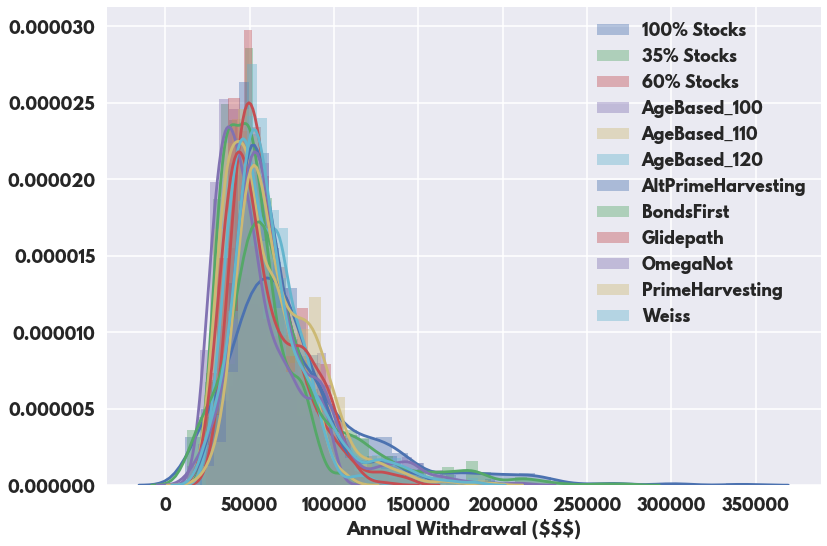

In [11]:
def make_all_stats():
    strategies_to_test = [
        harvesting.N_35_RebalanceHarvesting,
        harvesting.N_60_RebalanceHarvesting,
        harvesting.N_100_RebalanceHarvesting,
        harvesting.BondsFirst,
        harvesting.AltPrimeHarvesting,
        harvesting.PrimeHarvesting,
        harvesting.AgeBased_100,
        harvesting.AgeBased_110,
        harvesting.AgeBased_120,
        harvesting.Glidepath,
        harvesting.OmegaNot,
        harvesting.Weiss,
    ]

    #t = make_data_tables(strategies_to_test, lambda x: round(x.portfolio_r), years=40)
    t = make_data_tables(strategies_to_test, lambda x: round(x.withdraw_r), years=35)
    #t = make_data_tables(strategies_to_test, lambda x: round(x.portfolio_bonds/x.portfolio_n*100), years=40)

    if False:
        fn_mort = mortality.make_mortality_rate()
        for key in t:
            age = 65
            for c in t[key].columns:
                t[key][c] *= (1 - fn_mort(age, mortality.FEMALE))
                age += 1


    if False:
        for k in t:
            t[k].to_csv('CSV - withdraw - %s.csv' % k)
            

    df = None

    for key in sorted(t.keys()):
        #t[key].to_csv('CSV - portfolio - %s.csv' % key)
        stats = calculate_stuff(t[key], use_all_columns=True)

        if df is None:
            # We need to know the columns in order to define a data frame,
            # so we defer the creation until now
            df = pandas.DataFrame(columns=sorted(list(stats.keys())))
        df.loc[key] = stats
        
        seaborn.distplot(t[key].stack(), label=key, axlabel='Annual Withdrawal ($$$)')
        plt.legend(loc=0)

    return df

d = make_all_stats()
d.to_csv('CSV-comparison.csv')
d

In [12]:
def compare_year(year, lens, title):
    strategies_to_test = [
        harvesting.make_rebalancer(.6),
        harvesting.OmegaNot,
        harvesting.Weiss,
        harvesting.BondsFirst,
#        harvesting.AltPrimeHarvesting,
        harvesting.PrimeHarvesting,
    ]

    results = test_all(year, strategies_to_test, years=30)
    
    fig, ax = plt.subplots()

    if '%' not in title:
        plot.format_axis_labels_with_commas(ax.get_yaxis())

    plt.xlabel('Year of Retirement')
    plt.title('Retirement in Year %s (%s)' % (year, title))

    for strategy in (sorted(results.keys())):
        ax_n = fig.add_subplot(111, sharex=ax, sharey=ax)
        ws = [lens(n) for n in results[strategy]]
        ax_n.plot(ws, label=strategy)
        ax_n.set_ymargin(0.05)
    plt.legend(loc=0)
    ax.set_ylim(bottom=0)
    plt.show()

In [9]:
def chart_all(year):
    compare_year(year, lambda x: x.portfolio_stocks/x.portfolio_n*100, "Stock %")
    compare_year(year, lambda x: x.portfolio_n, "Portfolio (Nominal)")
    compare_year(year, lambda x: x.portfolio_r, "Portfolio (Real)")
    compare_year(year, lambda x: x.withdraw_n, "Withdrawals (Nominal)")
    compare_year(year, lambda x: x.withdraw_r, "Withdrawals (Real)")

In [10]:
chart_all(1940)

AssertionError: 

In [ ]:
survival_fn = mortality.make_mortality(mortality.ANNUITY_2000)

def get_rq(portfolio, age, withdrawal_pct):
    # I can't figure out how to to joint life expectancy so I'll
    # just use female life expectancy for now :/
    life_expectancy = mortality.life_expectancy(None, age)

    stock_pct = round(portfolio.stocks_pct * 100)
    mean = montecarlo.simba_mean[stock_pct]
    stddev = montecarlo.simba_stddev[stock_pct]
    
    return metrics.probability_of_ruin(mean, stddev, life_expectancy, float(withdrawal_pct))

def simulate_risk_quotient(series,
                            portfolio=(600000, 400000),
                            harvesting=harvesting.PrimeHarvesting,
                            withdraw=VPW,
                            live_until=None):
    portfolio = Portfolio(portfolio[0], portfolio[1])
    strategy = harvesting(portfolio).harvest()
    strategy.send(None)
    withdrawal_strategy = withdraw(portfolio, strategy).withdrawals()
    annual = []

    age = 65
    if not live_until:
        live_until = mortality.gen_age(survival_fn)

    # Withdrawals happen at the start of the year, so the first time
    # we don't have any performance data to send them....
    data = withdrawal_strategy.send(None)
    # Every year after the withdrawal we recalculate our risk quotient.
    rq = get_rq(portfolio, age, data.withdraw_n/data.portfolio_n)
    annual.append(rq)

    for d in series:
        age += 1
        if age > live_until:
            break

        data = withdrawal_strategy.send(d)
        rq = get_rq(portfolio, age, data.withdraw_n/data.portfolio_n)
        annual.append(rq)
    return annual

def compare_year(year):
    strategies_to_test = [
#        harvesting.N_30_RebalanceHarvesting,
#        harvesting.N_40_RebalanceHarvesting,
#        harvesting.N_50_RebalanceHarvesting,
        harvesting.make_rebalancer(.6),
#        harvesting.AltPrimeHarvesting,
#        harvesting.PrimeHarvesting,
    ]

    results = test_all(year, strategies_to_test, years=30)['Rebalancer']
    rqs = simulate_risk_quotient(series.iter_from(year), harvesting=harvesting.make_rebalancer(.6), live_until=95, withdraw=lambda p, s: VPW(p, s, years_left=50))
    
    def lens(x):
        return x.withdraw_r
    
    fig, ax = plt.subplots()

    plt.xlabel('Year of Retirement')
    plt.title('Retirement in Year %s' % year)

#    ax_n = fig.add_subplot(111, sharex=ax, sharey=ax)
    ws = [lens(n) for n in results]
    ax.plot(ws, label='Withdrawals', color='g')
#    ax.set_ymargin(0.05)
    ax.set_ylim(bottom=0)
    
    ax2 = ax.twinx()
    ax2.plot(rqs, label='Risk Quotient', color='r')
    ax2.set_ylim(bottom=0)

    plt.legend(loc=0)
    plt.show()
    
compare_year(1966)